In [8]:
import seaborn as sns # for data visualization
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import json
import glob
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)


# 211223160317
# 220104230735
# 220108230116

LOGFILES =  glob.glob('../logs/default_log_220127144858.json' )

print(LOGFILES)

#=== line colors and styles

linestyles = {
    #=======scenarios========
    'empty'      :   'dotted',
    'canonical'  :   'dashed',
    'floorplan'  :  'dashdot',
    #=======algorithms=======
    #------exploration------- 
    'Atlas'      :    'solid',
    #----relay placement-----
    'Recovery'   :    'solid',
    'SelfHealing':   'dashed',
    'Naive'      :  'dashdot',
}

linecolors = {
    #=======scenarios==========
    'empty'      :      'green',
    'canonical'  :       'blue',
    'floorplan'  :        'red',
    #=======algorithms=========
    #------exploration---------
    'Atlas'      :  'royalblue',
    #------relay placement-----
    'Recovery'   :     'purple',
    'SelfHealing':      'green',
    'Naive'      :       'orange',
     }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

['../logs/default_log_220127144858.json']


In [9]:

#=== gather data

log = []
for logfile in LOGFILES:
    with open(logfile,'r') as f:
        for line in f:
            log += [json.loads(line)]
            
lastRunNum = None
runNums    = 0
for run in log:
    if run['runNums']!= lastRunNum:
        runNums      += 1
        lastRunNum    = run['runNums']
            
print('runNums: {} TotalRuns: {}'.format(runNums,len(log)))

runNums: 1 TotalRuns: 1


300 300


c:\users\abuaishe\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


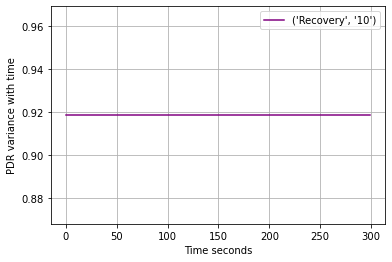

In [10]:
'''
###############################################################################
PDR Profile with Relays with various swarm sizes
###############################################################################
'''

#=== gather data
import matplotlib.ticker as mtick

data               = {}
scenarioNames      = []
swarmSizes         = []



for run in log:

    relayAlg       = run['relayAlg'] 
    navAlg         = run['navAlgorithm'] 
    
    numDotBots     = run['numDotBots']
    scenarioName   = str(numDotBots)
    scenarioNames += [scenarioName] 
       
    pdr            = run['pdrProfile']

    swarmSizes    += [numDotBots]
    pdrProfile     = run['pdrProfile']
    
    print(run['timeToFullMapping'], len(pdrProfile))
    
    if (scenarioName) not in data:
        data[(scenarioName)] = {}
    if relayAlg not in data[(scenarioName)]:
        data[(scenarioName)][relayAlg] = []
    data[(scenarioName)][relayAlg] += [pdrProfile]

for (k1,v1) in data.items():
    
    for (k2,profiles) in v1.items():
        
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}

    for ((scenario),v) in data.items():
        if scenario!=scenarioName:
            continue
        for (relayAlg,profile) in v.items():
            x1             = range(len(profile['mean']))
            #x             = [x*10 for x in x1]
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[relayAlg] = ax.errorbar(x=x1,y=y,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label= (relayAlg, scenario))
    ax.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=7000, decimals=None, symbol='%', is_latex=False))
    plt.xlabel('Time seconds')
    
    #plt.xlim(0, 300)
    plt.ylabel('PDR variance with time')

    #plt.ylim(0, 1)
    plt.legend()
    alllines = lines
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')

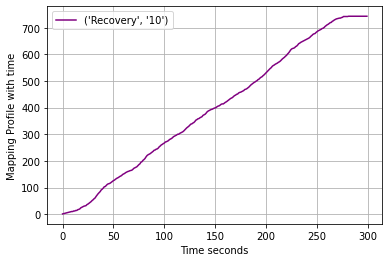

In [12]:
'''
###############################################################################
Mapping Profile with Relays with various swarm sizes
###############################################################################
'''

#=== gather data
import matplotlib.ticker as mtick

data               = {}
scenarioNames      = []
allNumRobots       = []


for run in log:

    relayAlg       = run['relayAlg'] 
    numDotBots     = run['numDotBots']
    scenarioName  = str(numDotBots)
    scenarioNames += [scenarioName] 
    
    navAlg         = run['navAlgorithm'] 
    pdr            = run['pdrProfile']
    numDotBots     = run['numDotBots']
    allNumRobots  += [numDotBots]
    mappingProfile = run['mappingProfile']
    
    if (scenarioName) not in data:
        data[(scenarioName)] = {}
    if relayAlg not in data[(scenarioName)]:
        data[(scenarioName)][relayAlg] = []
    data[(scenarioName)][relayAlg] += [mappingProfile]

for (k1,v1) in data.items():
    
    for (k2,profiles) in v1.items():
        
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}

    for ((scenario),v) in data.items():
#         if numDotBots!=50:
#             continue
        if scenario!=scenarioName:
            continue
        for (relayAlg,profile) in v.items():
            x             = range(len(profile['mean']))
            #x             = [x*10 for x in x1]
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[relayAlg] = ax.errorbar(x=x,y=y,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label=(relayAlg, scenario))
    ax.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=7000, decimals=None, symbol='%', is_latex=False))
    plt.xlabel('Time seconds')
    
    #plt.xlim(0, 300)
    plt.ylabel('Mapping Profile with time')

    #plt.ylim(0, 1)
    plt.legend()
    alllines = lines
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')

NameError: name 'ax2' is not defined

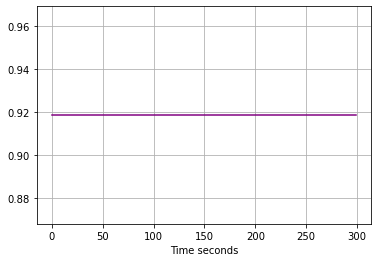

In [13]:
'''
###############################################################################
PDR vs. Time with relays with various swarm sizes
###############################################################################
'''

#=== gather data
import matplotlib.ticker as mtick

data               = {}
scenarioNames      = []
allNumRobots       = []


for run in log:

    relayAlg       = run['relayAlg'] 
    numDotBots     = run['numDotBots']
    scenarioName  = str(numDotBots)
    scenarioNames += [scenarioName] 
    
    navAlg         = run['navAlgorithm'] 
    pdrProfile     = run['pdrProfile']
    numDotBots     = run['numDotBots']
    allNumRobots  += [numDotBots]
    #mappingProfile = run['mappingProfile']
    
    if (scenarioName) not in data:
        data[(scenarioName)] = {}
    if relayAlg not in data[(scenarioName)]:
        data[(scenarioName)][relayAlg] = []
    data[(scenarioName)][relayAlg] += [pdrProfile]

for (k1,v1) in data.items():
    
    for (k2,profiles) in v1.items():
        
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}

    for ((scenario),v) in data.items():
        if scenario!=scenarioName:
            continue
        for (relayAlg,profile) in v.items():
            x             = range(len(profile['mean']))
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[relayAlg] = ax.errorbar(x=x,y=y,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label=(relayAlg, scenario))
    ax.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=7000, decimals=None, symbol='%', is_latex=False))
    plt.xlabel('Time seconds')
    
    ax2.errorbar(x=timeline,y=relayProfile,marker= 'o',color='black',linestyle=linestyles[relayAlg],)

    ax.set_ylabel('PDR variance with time')
    ax2.set_ylabel('Number of Relays Placed')
    ax.legend(loc=8)

    #plt.ylim(0, 1)
    plt.legend()
    alllines = lines
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

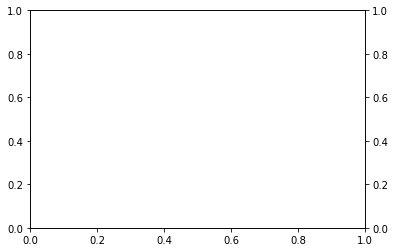

In [14]:
'''
###############################################################################
PDR vs. Time with relays
###############################################################################
'''

#=== gather data

data               = {}
scenarioNames      = []
allNumRobots       = []
pdrData            = []


for run in log:
    pdrData      = run['pdrProfile']
    swarmSize    = run['numDotBots']
    timeline     = run['timeline']
    relayAlg     = run['relayAlg']
    relayProfile = run['relayProfile']
    (fig,ax)     = plt.subplots()
    ax2 = ax.twinx()
    
    max_relays = relayProfile[-1] +1 

    ax.errorbar(x=timeline,y=pdrData,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label=(relayAlg, swarmSize))
    ax2.errorbar(x=timeline,y=relayProfile,color='black',linestyle="dotted",)
    ax.grid(True, zorder=5)
    #ax2.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1))
    ax2.yaxis.set_ticks(np.arange(0, max_relays))
    ax.set_xlabel('Time seconds')
    ax.set_ylabel('PDR variance with time')
    ax2.set_ylabel('Number of Relays Placed')
    plt.xscale('log')
    ax.legend(loc=6)
    plt.show()
    print(run['numRelays'])
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')